# Alpha Indices

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(schoRsch)
library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

indices <- Indices()

In [2]:
benchmark <- "NIFTY 50 TR"

indexName <- "NIFTY ALPHA 50 TR"
indexName2 <- "NIFTY100 ALPHA 30 TR"

#indexName2 <- "NIFTY ALPHA 50 TR"
#indexName <- "NIFTY100 ALPHA 30 TR"

startDt <- as.Date("2004-01-01")
lookback <- 200 #days: to calculate standard deviation
lookforward <- 200 #days: to calculate cumulative returns
numBins <- 10 #number of bins: to bucket standard deviations
binLookback <- 500 #days: rolling window for bucketing standard deviations

In [3]:
benchTs <- indices$NseTimeSeries() %>%
    filter (NAME == benchmark & TIME_STAMP >= startDt) %>%
    select (TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

alphaTs <- indices$NseTimeSeries() %>%
    filter (NAME == indexName & TIME_STAMP >= startDt) %>%
    select (TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

alphaTs2 <- indices$NseTimeSeries() %>%
    filter (NAME == indexName2 & TIME_STAMP >= startDt) %>%
    select (TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

bondTs <- indices$IndiaGsecTimeSeries() %>%
    filter (NAME == "0_5" & TIME_STAMP >= startDt) %>%
    select (TIME_STAMP, TRI) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

## Plot standard deviation

In [4]:
pxTs <- merge(xts(benchTs[,2], benchTs$TIME_STAMP), #benchmark
              xts(alphaTs[,2], alphaTs$TIME_STAMP), #primary alpha index
              xts(alphaTs2[,2], alphaTs2$TIME_STAMP), #the other one
              xts(bondTs[,2], bondTs$TIME_STAMP)) #bond index
pxTs[,4] <- na.locf(pxTs[,4])
pxTs <- na.omit(pxTs)

In [5]:
dRetTs <- merge(dailyReturn(pxTs[,1]), dailyReturn(pxTs[,2]), dailyReturn(pxTs[,3]), dailyReturn(pxTs[,4]))
dRetTs <- dRetTs[-1,]

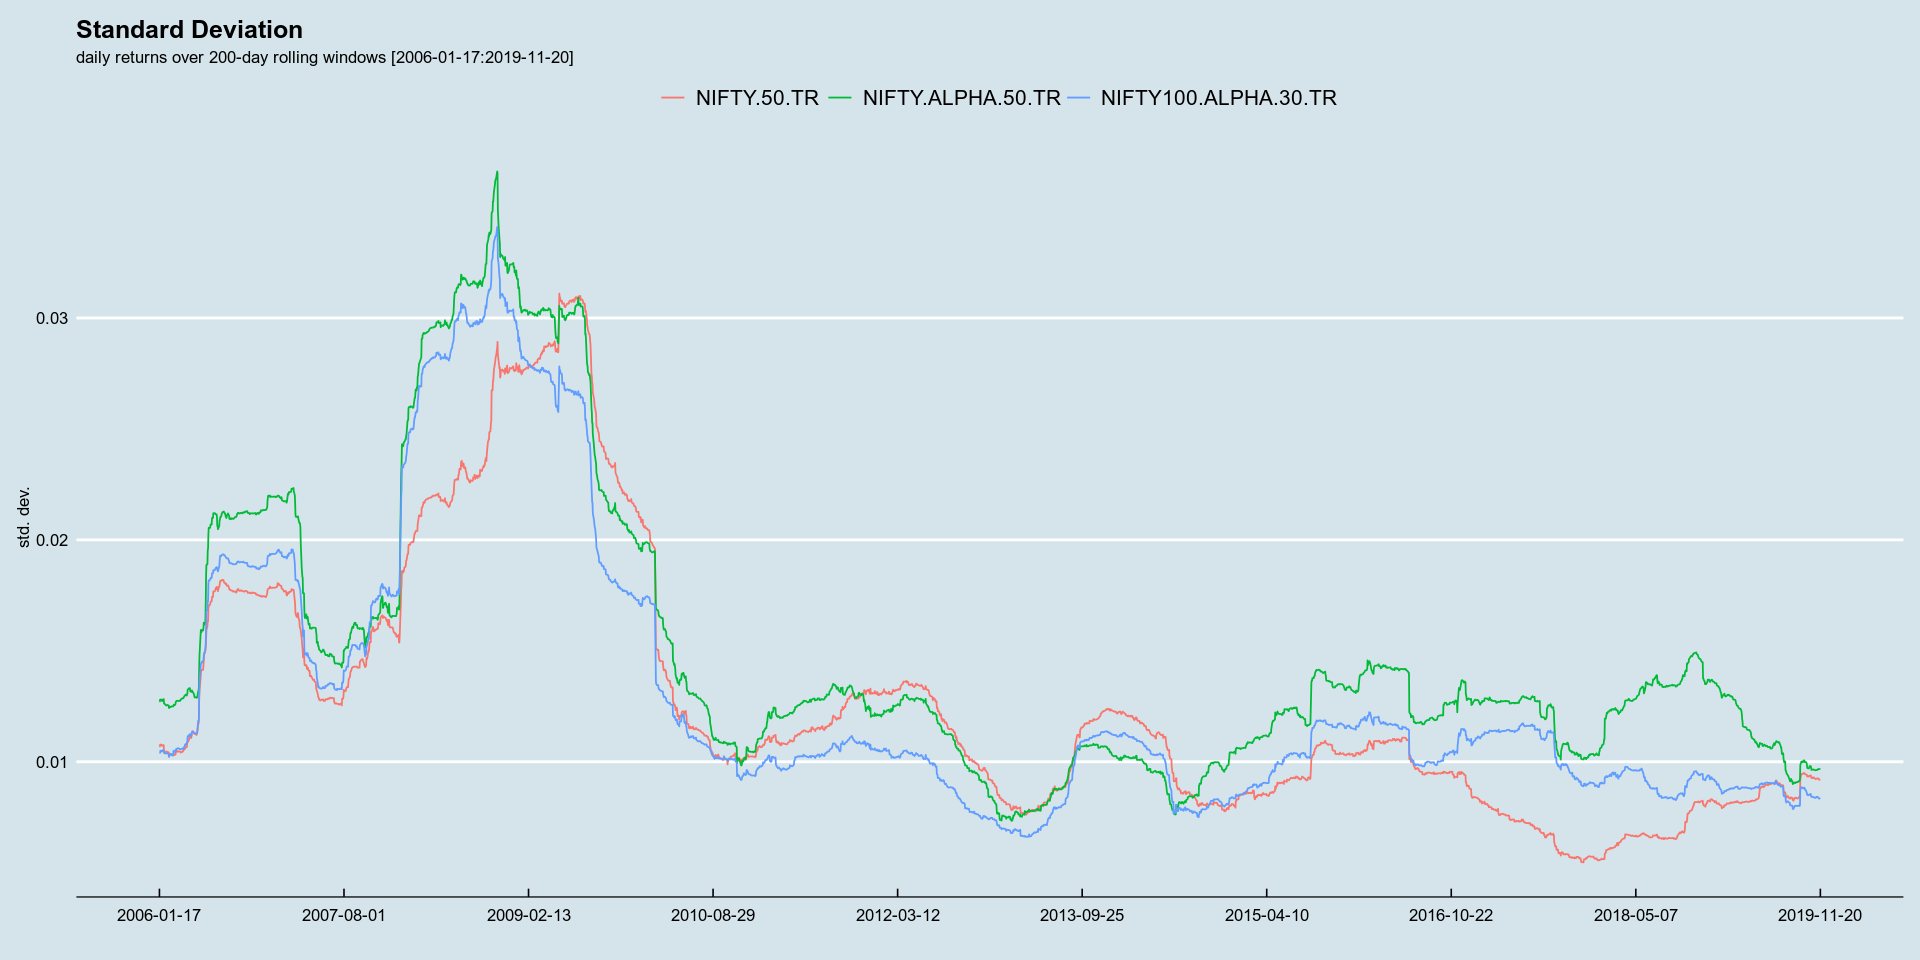

In [6]:
sdTs <- na.omit(merge(rollapply(dRetTs[,1], lookback, sd),
             rollapply(dRetTs[,2], lookback, sd),
             rollapply(dRetTs[,3], lookback, sd)))
names(sdTs) <- c(benchmark, indexName, indexName2)
sdDf <- data.frame(sdTs)
sdDf$T <- index(sdTs)

startDate <- index(first(sdTs))
endDate <- index(last(sdTs))
xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

toPlot <- melt(sdDf, id='T')
ggplot(toPlot, aes(x=T, y=value, color=variable)) +
        theme_economist() +
        geom_line() + 
        scale_x_date(breaks = xAxisTicks) +
        labs(x='', y='std. dev.', fill='', color='', 
             title='Standard Deviation', 
             subtitle=sprintf("daily returns over %d-day rolling windows [%s:%s]", lookback, startDate, endDate)) 

In [7]:
trainingSet <- sprintf("%s/%s", index(dRetTs[1,1]), index(dRetTs[nrow(dRetTs)/2,1]))
testSet <- sprintf("%s/", index(dRetTs[nrow(dRetTs)/2,1])+1)

eqSd <- rollapply(dRetTs[trainingSet, 2], lookback, sd)
cumEqRets <- 100*rollapply(dRetTs[trainingSet, 2], lookforward, Return.cumulative)

In [8]:
relXts <- merge(eqSd, stats::lag(cumEqRets, -lookforward))

In [9]:
relXts <- na.omit(relXts)
sdBins <- rollapply(relXts[,1], binLookback, function(X) {
    last(ntiles(data = data.frame(SD = coredata(X)), dv=1, bins=numBins))
})

relXts <- na.omit(merge(relXts, sdBins))

In [10]:
toPlot <- data.frame(relXts[trainingSet,c(2, 3)])
names(toPlot) <- c('RETURNS', 'DECILE_SD')
toPlot$DECILE_SD <- as.factor(toPlot$DECILE_SD)

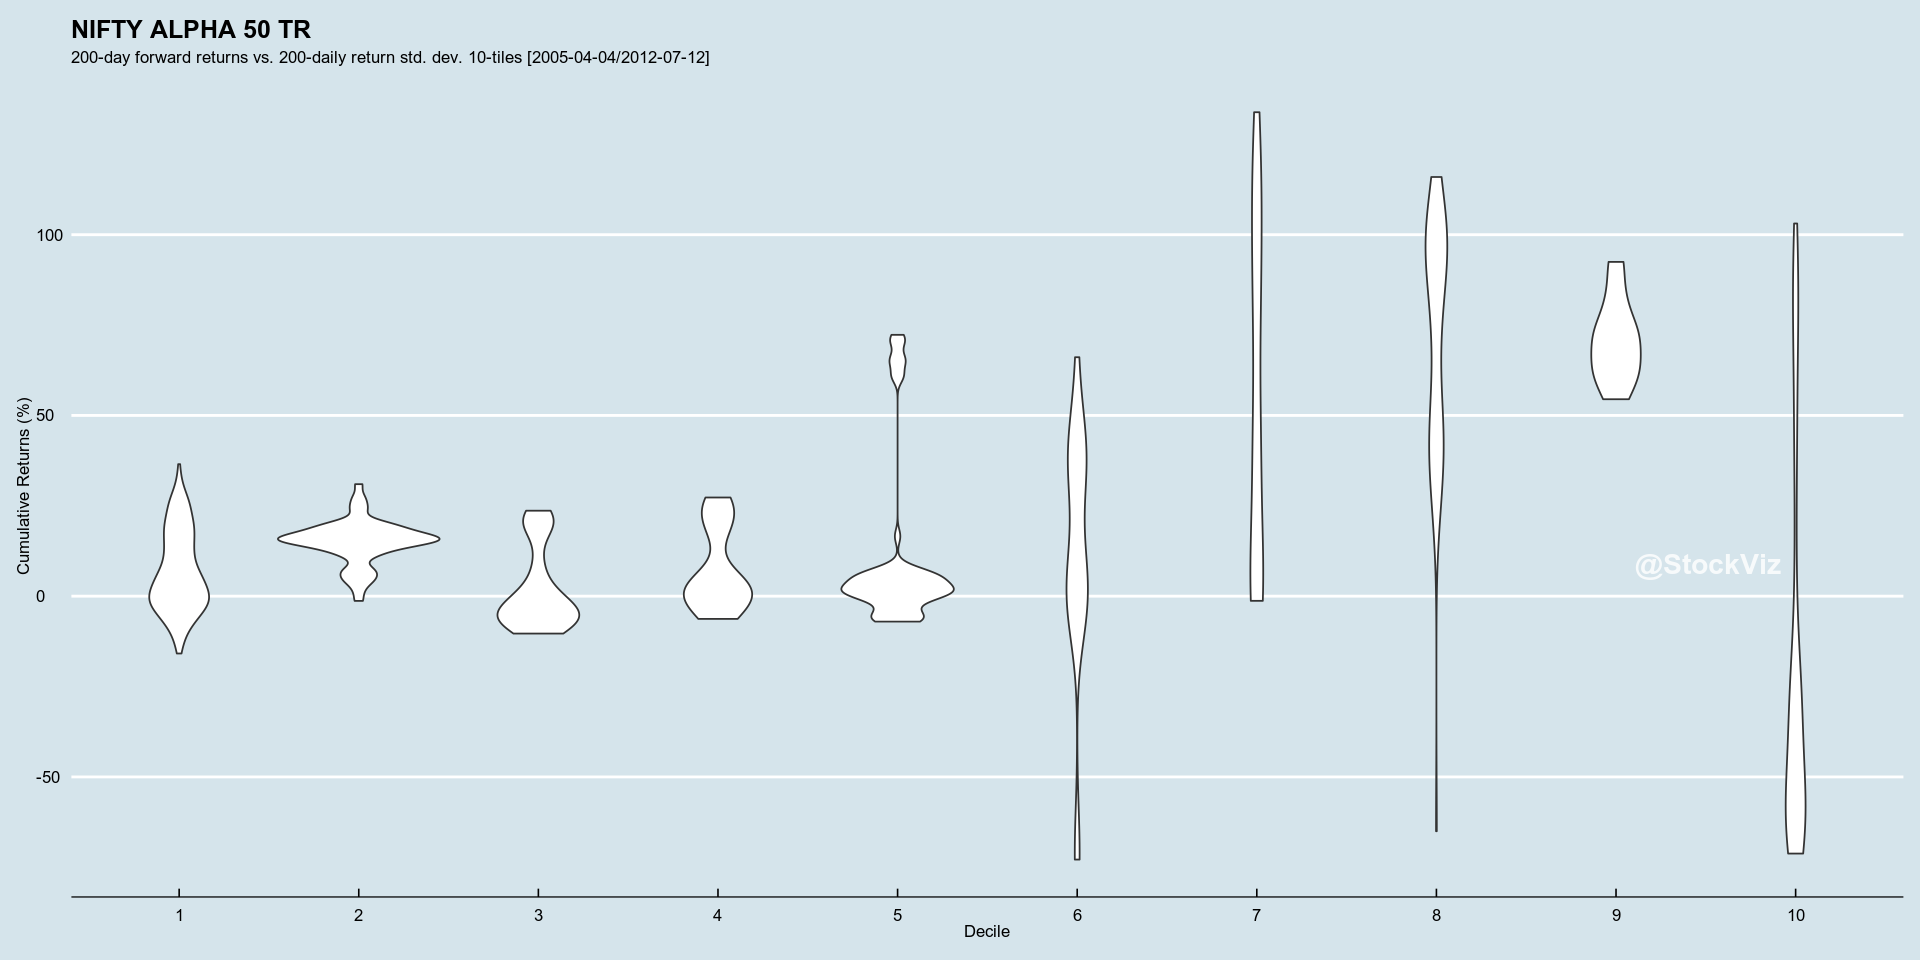

In [11]:
ggplot(toPlot, aes(x=DECILE_SD, y=RETURNS)) + 
    theme_economist() +
    geom_violin() +
    labs(x='Decile', y='Cumulative Returns (%)', fill='', 
         title=indexName, 
         subtitle=sprintf("%d-day forward returns vs. %d-daily return std. dev. %d-tiles [%s]", lookforward, lookback, numBins, trainingSet)) +
    annotate("text", x=numBins, y=0, 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

### Training

In [12]:
trainingData <- merge(dRetTs[trainingSet, c(1, 2, 4)], sdBins)
trainingData <- merge(trainingData, stats::lag(trainingData[, c(1,2,3)], -1))
trainingData <- trainingData[, c(4, 5, 6, 7)]
names(trainingData) <- c('DECILE_SD', 'BENCH', 'E_LAG_1', 'B_LAG_1')
trainingData <- na.omit(trainingData)

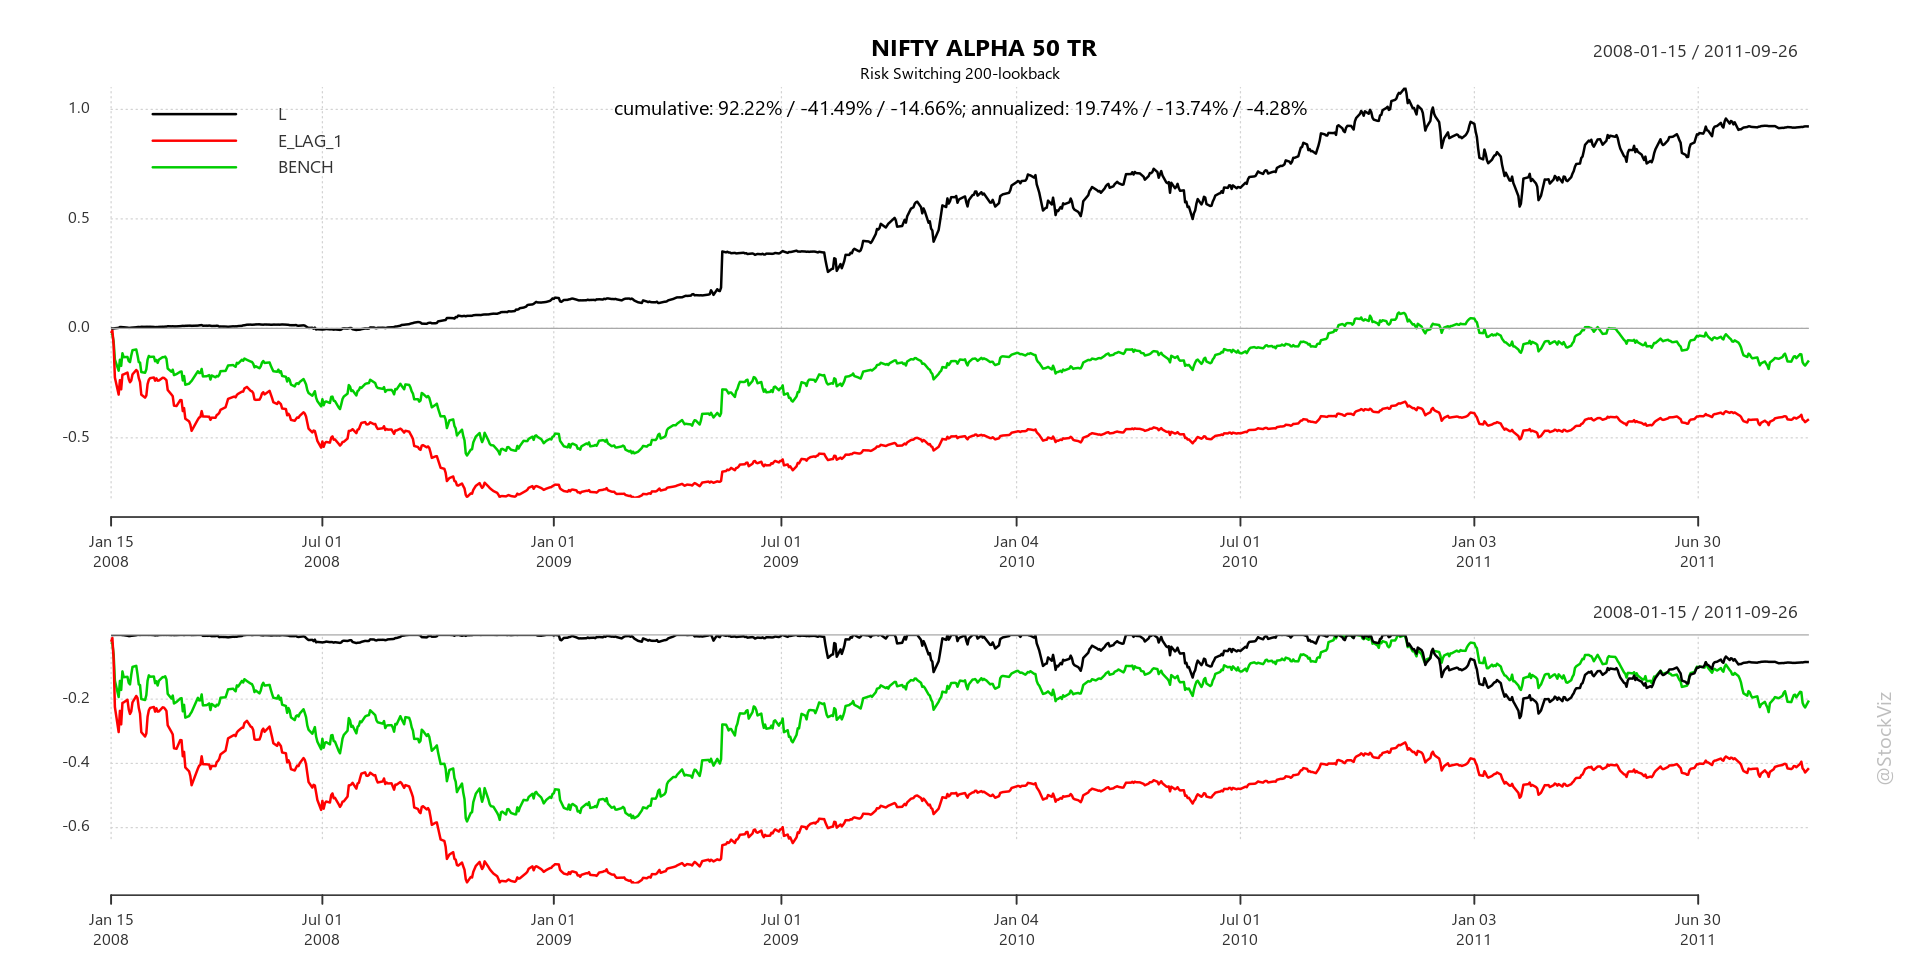

In [13]:
trainingData$L <- ifelse(trainingData$DECILE_SD %in% c(1, 2, 3, 4, 5), trainingData$E_LAG_1, trainingData$B_LAG_1)
Common.PlotCumReturns(trainingData[, c('L', 'E_LAG_1', 'BENCH')], sprintf("%s", indexName), sprintf("Risk Switching %d-lookback", lookback))

### Test

In [14]:
eqSd2 <- rollapply(dRetTs[testSet, 2], lookback, sd)
sdBins <- rollapply(eqSd2, binLookback, function(X) {
    last(ntiles(data = data.frame(SD = coredata(X)), dv=1, bins=numBins))
})
testData <- merge(dRetTs[testSet, c(1, 2, 4)], sdBins)
testData <- merge(testData, stats::lag(testData[, c(1,2,3)], -1))
testData <- testData[, c(4, 5, 6, 7)]
names(testData) <- c('DECILE_SD', 'BENCH', 'E_LAG_1', 'B_LAG_1')
testData <- na.omit(testData)

## Going long first half

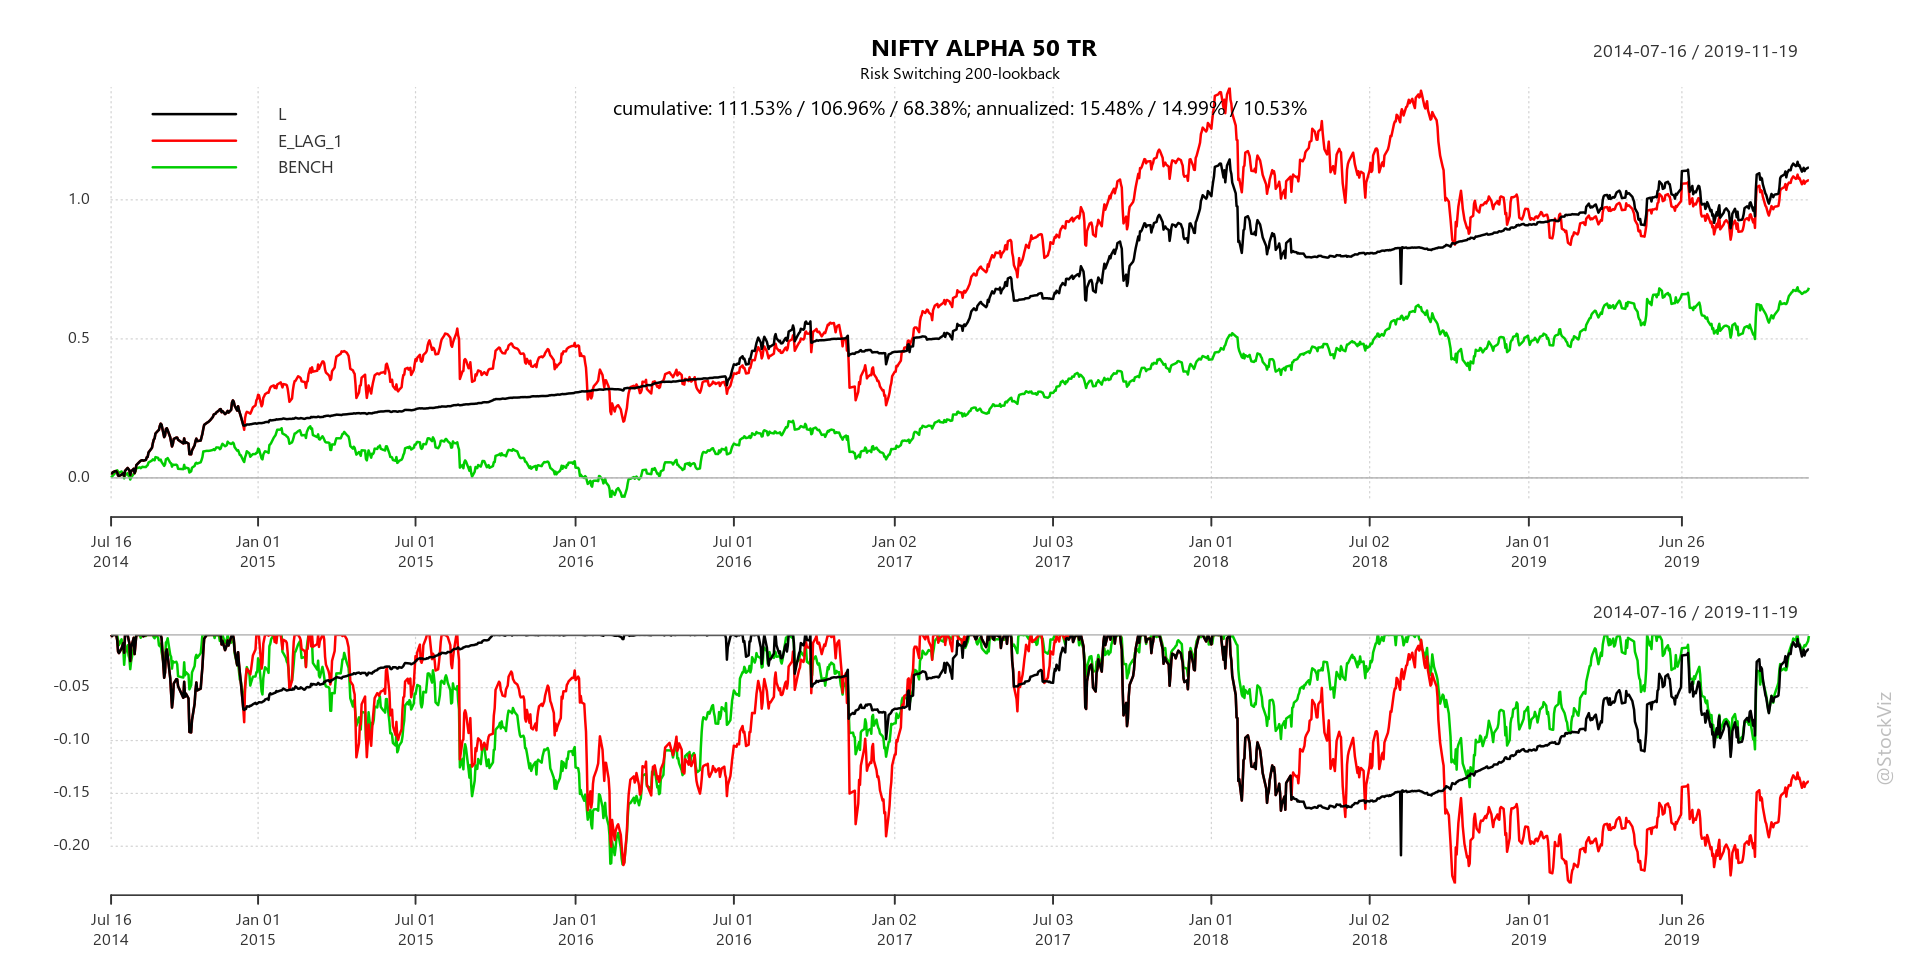

In [15]:
testData$L <- ifelse(testData$DECILE_SD %in% c(1, 2, 3, 4, 5), testData$E_LAG_1, testData$B_LAG_1)
Common.PlotCumReturns(testData[, c('L', 'E_LAG_1', 'BENCH')], sprintf("%s", indexName), sprintf("Risk Switching %d-lookback", lookback))

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!